# Exploring Sonoma County animal shelter intake and outcome data 
## Data source
For this data analysis, we are using the Sonoma County Animal Shelter Intake and Outcome dataset collected and made publicly available by Sonoma County with the purpose of helping the community better understand the animals being cared for by the shelter.

The dataset includes each animal’s name, type, breed, color, sex, size, date of birth, kennel/impound details and ID, intake/outcome date, days in shelter, intake/outcome types, health condition, and outcome location. The data spans from August 2013 to May 2023.
## Questions we seek to answer
- What types of animals are cared for by the shelter?
- Has the number of intakes increased or decreased over time?
- During which month does the shelter have the most intakes?
- What are the most common outcomes?
- During which month does the shelter have the most adoptions?
- Does age affect the likelihood of an animal's adoption?
- Is age a factor in how long an animal stays at the shelter?
- Is gender a factor in how long an animal stays at the shelter?

## Importing needed libraries/modules and reading the data from the CSV

In [20]:
# Importing needed libraries/modules
from pandas import read_csv, to_datetime, Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import gmplot
from IPython.display import IFrame
from project_functions import monthly_in_out, convertAgeToYears, convertDaysInShelterToYears, requestIntakeDateYearInput, type_pie_chart, requestOutcomeDateYearInput
from seaborn import scatterplot
from configAPI import APIkey
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Open data file
df = read_csv('intake_and_outcome_data.csv')

## Cleaning up/converting data
### Converting the name; birth, intake, and outcome date; and outcome type columns

In [21]:
# Replacing all NaN values of name column with "No name"
df["Name"].fillna("No name", inplace=True)

# Converts string dates to datetime dtypes
df["Date Of Birth"] = to_datetime(df["Date Of Birth"])
df["Intake Date"] = to_datetime(df["Intake Date"])
df["Outcome Date"] = to_datetime(df["Outcome Date"])

# Replacing all NaN values of outcome type column with "Pending"
df["Outcome Type"].fillna("Pending", inplace=True)

# Remove any duplicate categories
# Replacing all RTOS values of outcome type column with "RETURN TO OWNER"
df["Outcome Type"].replace("RTOS", "RETURN TO OWNER", inplace=True)
# Replacing all OS APPT values of intake type column with "OWNER SURRENDER"
df["Intake Type"].mask(df["Intake Type"] == "OS APPT", "OWNER SURRENDER", inplace=True)

### Calculating age and adding Age In Days and Age Group columns

In [22]:
# Find age in days of animal on intake date if birth date provided
birth_dates = np.array(df["Date Of Birth"], dtype='datetime64[D]')
intake_dates = np.array(df["Intake Date"], dtype='datetime64[D]')
ages = np.array((intake_dates - birth_dates), dtype="int")
ages = np.where(ages < 0, 0, ages) # changes age to zero if born after intake
ages = np.where(np.isnat(birth_dates), np.nan, ages) # gives NaN value if no birthday provided and changes dtype to float64
df['Age In Days'] = ages

# Creating age groups
df["Age Group"] = ages.astype("str")
df["Age Group"].mask(df["Age In Days"] < 366, "Young", inplace=True)
df["Age Group"].mask(df["Age In Days"] > 365, "Adult", inplace=True)
df["Age Group"].mask(df["Age In Days"] > 3650, "Senior", inplace=True)
df["Age Group"].mask(df["Age Group"] == 'nan', "Unknown", inplace=True)

# Separating sex and spay/neuter status
# If sex is listed (rather than Neutered or Spayed), it is assumed that the animal is not spayed/neutered.
df["Fixed"] = df["Sex"]
df["Fixed"].mask(df["Fixed"] == "Female", "Unaltered", inplace=True)
df["Fixed"].mask(df["Fixed"] == "Male", "Unaltered", inplace=True)

## Preview the data

In [192]:
# Preview 
df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Zip Codes,Age In Days,Age Group,Fixed
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,2009-10-29,K22-043412,TRUCK,A396382,2022-12-26,2022-12-26,0,STRAY,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1,26077.0,4806.0,Senior,Neutered
1,No name,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaT,K23-044095,TRUCK,A416206,2023-03-15,2023-03-15,0,STRAY,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1,NaN,NaN,Unknown,Unknown
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,2020-03-10,K23-044090,DS80,A399488,2023-03-15,2023-03-15,0,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1,31039.0,1100.0,Adult,Neutered
3,No name,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,2011-06-26,K22-043405,VET,A414520,2022-12-23,2022-12-27,4,STRAY,FIELD,DISPOSAL,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1,26076.0,4198.0,Senior,Spayed
4,PUDGY,DOG,CHIHUAHUA SH/SCHIPPERKE,TAN,Neutered,MED,2013-07-20,K23-043813,DA27,A415428,2023-02-08,2023-03-15,35,OWNER SURRENDER,OVER THE COUNTER,TRANSFER,MUTTVILLE,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,94103.0,"94103(37.77672, -122.40779)",1,28853.0,3490.0,Adult,Neutered


## Animal types

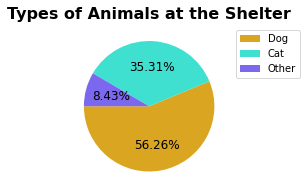

In [193]:
animal_types = df["Type"].value_counts()
type_pie_chart(animal_types, "Types of Animals at the Shelter")

## Animal intakes
### Animal intakes per month
To better see the data for each year, we can plot monthly intakes for the years included in the data set (2013-2023) based on user input. To do this, we create a pandas dataframe based on the inputted year and use dt.month.value_counts() to get a count of each month in the dataframe. We then plot this information on a bar graph.

Enter a year between 2013 and 2023 to view number of intakes per month:  2020


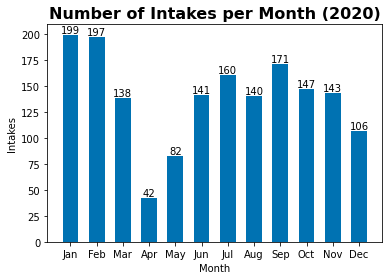

Total intakes for 2020: 1,666


In [194]:
# Find number of intakes by month for specific year
year = requestIntakeDateYearInput()
df_in_date = df[df["Intake Date"].dt.strftime("%Y") == f"{year}"]
total_annual_intakes = len(df_in_date.index)
monthly_intakes = Series.sort_index(df_in_date["Intake Date"].
                                    dt.month.value_counts())

# Plot monthly intakes
monthly_in_out(monthly_intakes, year, "Intakes")
print(f"Total intakes for {year}: {total_annual_intakes:,}")

### Average animal intakes per month
We also wanted to find out how many intakes the shelter has on average for each month of the year. We use dt.month.value_counts() to get a count of the total number of intakes for each month for all years. To find the average of each month, we divide the total intakes for each month by the number of years in the dataset.

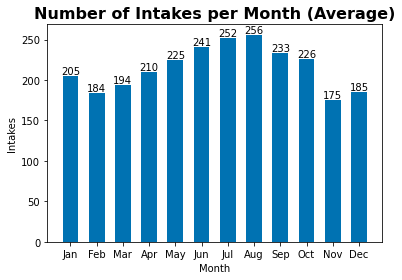

In [195]:
# Find average number of intakes for each month
all_monthly_intakes = (Series.sort_index(df["Intake Date"].dt.month.value_counts())).to_numpy() 
num_of_years = round((df["Intake Date"].max()-df["Intake Date"].min())/np.timedelta64(1, 'Y'), 2)
avg_monthly_intakes = Series((all_monthly_intakes/num_of_years).round(decimals=0), index=[x for x in range(1, 13)])

monthly_in_out(avg_monthly_intakes, "Average", "Intakes")

## Outcomes
### Outcome types


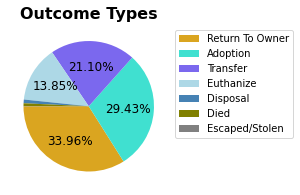

In [219]:
# Plot outcome types
outcomes = df["Outcome Type"].mask(df["Outcome Type"] == "Pending").value_counts()
type_pie_chart(outcomes, "Outcome Types")

### Outcomes per month
Note: There were no outcomes listed for 2013.

Enter a year between 2014 and 2023 to view number of outcomes per month:  2020


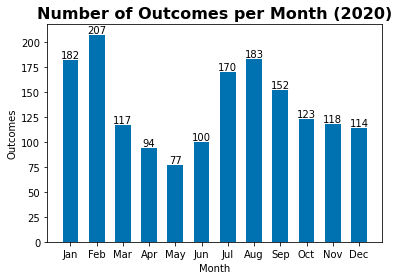

In [220]:
# Find number of outcomes by month for specific year
year = requestOutcomeDateYearInput("number of outcomes per month")
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]
monthly_outcomes = Series.sort_index(df_out_date["Outcome Date"].
                                     dt.month.value_counts())
# Plot monthly outcomes
monthly_in_out(monthly_outcomes, year, "Outcomes")

## Outcome locations
### Visualize animal outcome locations in a Google Map based on user input year

In [221]:
#Get user input year
year = requestOutcomeDateYearInput("outcome locations")
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]

#create a default Google Map
gmap=gmplot.GoogleMapPlotter(lat='38.43807',lng='-122.71247', zoom=7)
gmap.apikey = APIkey()

#Iterate through the data set
for index, row in df_out_date.iterrows():
    #Get location data
    location = str(row["Location"])
    #Massage data, only plot locations that have a lat, long
    if '(' in location:
        location = str(row["Location"]).split('(')[1].removesuffix(')')
        latitude = float(location.split(',')[0])
        longitude = float(location.split(',')[1])
        title = row["Name"]
        if title == "No name":
            title = ''
        breed = row["Breed"]
        title = f"Name: {title} - Breed: {breed}"
        gmap.marker(latitude, longitude, title=title)
gmap.draw("map.html")
IFrame(src='map.html', width=700, height=600)

Enter a year between 2014 and 2023 to view outcome locations:  2020


## Duration of stay at shelter

In [199]:
# Calculate the average length of stay
avg_los = np.nanmean(df["Days in Shelter"])
print(f"The average length of stay for an animal at the shelter is {avg_los:.3} days.")

The average length of stay for an animal at the shelter is 18.4 days.


### Gender and length of stay

Female average days in shelter: 11.997448256308477
Male average days in shelter: 11.865361942937986
Neutered average days in shelter: 23.302294845608554
Spayed average days in shelter: 24.19804721655494
Unknown average days in shelter: 5.058691756272402


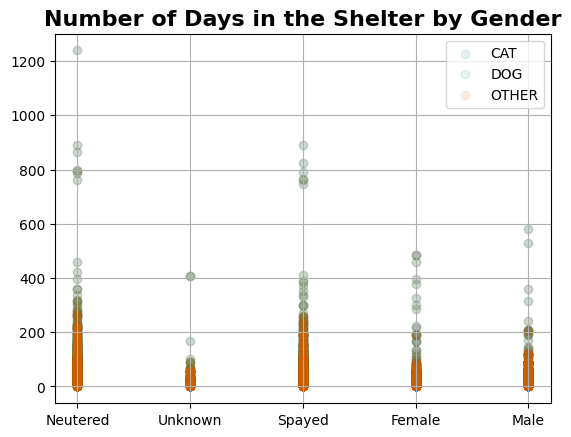

In [64]:
#Get average days in shelter based on gender
for gender in np.unique(df["Sex"]):
    avgGenderDiS = np.average(np.array(df.loc[df["Sex"] == gender,"Days in Shelter"], dtype="float"))
    print(f"{gender} average days in shelter: {avgGenderDiS}")

#Plot days in shelter by gender, each color denotes the type of animal
fig, ax = plt.subplots()
ax.set_title("Number of Days in the Shelter by Gender", size=16, weight="bold")
plt.legend(np.unique(df["Type"]))
for type in np.unique(df["Type"]):
    ax.scatter(x=df["Sex"],y=df["Days in Shelter"], label=type, alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

### Age and length of stay for adopted animals
#### Does the age of the animal influence how long they stay at the shelter before being adopted?

The average age of an animal upon entering the shelter is 3.4 years.
The average age of an animal that gets adopted is 1.8 years.
The average length of stay for an animal that gets adopted is 33.8 days, versus 18.4 days, the average length of stay for an animal regardless of outcome.


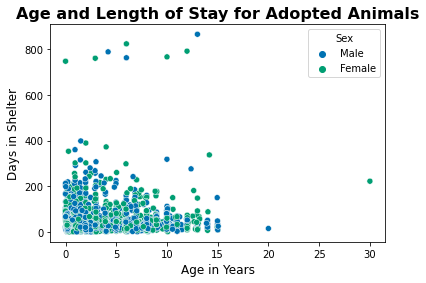

In [225]:
avg_age_in_years = np.nanmean(convertAgeToYears(df["Age In Days"]))
avg_age_of_adopted = np.nanmean(convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")))
avg_los_adopted = np.nanmean(df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"))
print(f"The average age of an animal upon entering the shelter is {avg_age_in_years:.2} years.")
print(f"The average age of an animal that gets adopted is {avg_age_of_adopted:.2} years.")
print(f"The average length of stay for an animal that gets adopted is {avg_los_adopted:.3} days, versus {avg_los:.3} days, the average length of stay for an animal regardless of outcome.")

genders = df["Sex"].mask(df["Sex"] == "Neutered", "Male", inplace=False)
genders = genders.mask(genders == "Spayed", "Female", inplace=False)
plt.figure(figsize=(6, 4))
plt.title("Age and Length of Stay for Adopted Animals", size=16, weight="bold")
plt.ylabel("Days in Shelter", size=12)
plt.xlabel("Age in Years", size=12)
scatterplot(x=convertAgeToYears(df["Age In Days"].mask(df["Outcome Type"] != "ADOPTION")), y=df["Days in Shelter"].mask(df["Outcome Type"] != "ADOPTION"), hue=genders.where(genders != "Unknown"))
plt.show()

## Adoptions
### Animal adoption rate

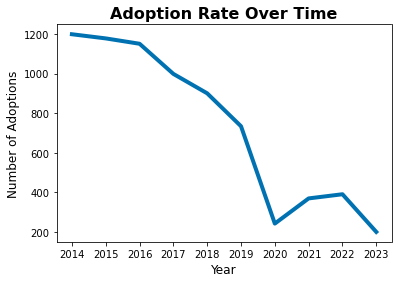

In [206]:
adoptions = df[["Outcome Date", "Outcome Type"]].mask(df["Outcome Type"] != "ADOPTION", inplace=False)
yearly_adoptions =  Series.sort_index(adoptions["Outcome Date"].dt.year.value_counts())

plt.figure(figsize=(6, 4))
plt.plot(yearly_adoptions, linewidth=4)
plt.title("Adoption Rate Over Time", size=16, weight="bold")
plt.xticks(yearly_adoptions.index.values)
plt.ylabel("Number of Adoptions", size=12)
plt.xlabel("Year", size=12)
plt.show()

### Animal adoptions versus intakes and all outcomes

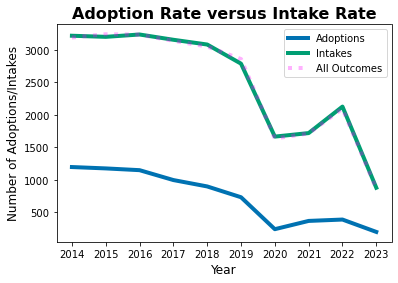

In [207]:
# Plot intakes/adoptions over time 
yearly_intakes =  Series.sort_index(df["Intake Date"].dt.year.value_counts())
yearly_outcomes =  Series.sort_index(df["Outcome Date"].dt.year.value_counts())
plt.figure(figsize=(6, 4))
plt.plot(yearly_adoptions, label="Adoptions", linewidth=4)
plt.plot(yearly_intakes[1:], label="Intakes", linewidth=4)
plt.plot(yearly_outcomes, label="All Outcomes", alpha=0.3, color="magenta", linestyle=":", linewidth=4)
plt.xticks(yearly_adoptions.index.values)
plt.title("Adoption Rate versus Intake Rate", size=16, weight="bold")
plt.ylabel("Number of Adoptions/Intakes", size=12)
plt.xlabel("Year", size=12)
plt.legend()
plt.show()

## Predicting outcomes

In [208]:
outcome_df = DataFrame(df[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition", "Outcome Type"]]).dropna()

# Update gender column to be male or female
outcome_df["Sex"].mask(df["Sex"] == "Neutered", "Male", inplace=True)
outcome_df["Sex"].mask(df["Sex"] == "Spayed", "Female", inplace=True)

# Update outcome type column to be either positive or negative
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "RETURN TO OWNER", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "ADOPTION", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] == "TRANSFER", "Positive", inplace=True)
outcome_df["Outcome Type"].mask(outcome_df["Outcome Type"] != "Positive", "Negative", inplace=True)

# Preview data
outcome_df.head()

,Type,Size,Sex,Fixed,Age Group,Intake Type,Intake Condition,Outcome Type
0,DOG,SMALL,Male,Neutered,Senior,STRAY,UNKNOWN,Positive
1,OTHER,SMALL,Unknown,Unknown,Unknown,STRAY,UNKNOWN,Negative
2,DOG,MED,Male,Neutered,Adult,STRAY,UNKNOWN,Positive
3,CAT,SMALL,Female,Spayed,Senior,STRAY,UNKNOWN,Negative
4,DOG,MED,Male,Neutered,Adult,OWNER SURRENDER,UNKNOWN,Positive


### Interger-encoding
sklearn.preprocessing.LabelEncoder() was used to integer-encoded the data values, which were encoded based on alphabetical order.
For reference, we also created a dictionary that maps the category/feature to its integer.

In [212]:
# Create instance of the label encoder
label_encoder = LabelEncoder()
feature_dict = {}
# Loop through dataframe headings to encode each feature variable as an integer within a category
for category in outcome_df.columns:
    sub_cat = outcome_df[category].unique()
    outcome_df[category] = label_encoder.fit_transform(outcome_df[category])
    encoded = outcome_df[category].unique()
    sub_dict = dict(zip(sub_cat, encoded))
    feature_dict[category] = sub_dict

# Preview encoded data
outcome_df.head()

,Type,Size,Sex,Fixed,Age Group,Intake Type,Intake Condition,Outcome Type
0,1,4,1,0,1,5,3,1
1,2,4,2,3,2,5,3,0
2,1,2,1,0,0,5,3,1
3,0,4,0,1,1,5,3,0
4,1,2,1,0,0,3,3,1


### Train and test model
We then split the outcome_df dataframe to get a training dataset and a test dataset. After creating an instance of sklearn.naive_bayes.CategoricalNB, we fit the model with our training dataset, outcome_train. We then score the accuracy of the model based on the test dataset. 

In [214]:
# Create training data
outcome_train = DataFrame(outcome_df[:14637])

# Create test data
outcome_test = DataFrame(outcome_df[14637:])

# Create and train model
categories = outcome_train[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition"]]
outcomes = outcome_train["Outcome Type"].values
model = CategoricalNB(alpha=1)
model.fit(categories, outcomes)

# Test model
test_data = outcome_test[["Type", "Size", "Sex", "Fixed", "Age Group", "Intake Type", "Intake Condition"]]
predicted_outcomes = model.predict(test_data)
test_dict = {"Predictions": predicted_outcomes, "Outcomes": outcome_test["Outcome Type"].values}
test_df = DataFrame(test_dict)
print(test_df)
test_accuracy = model.score(test_data, outcome_test["Outcome Type"].values)
print(f"Accuracy score for test data: {test_accuracy:.2%}")

       Predictions  Outcomes
0                1         1
1                1         1
2                0         1
3                1         1
4                1         1
...            ...       ...
10508            1         1
10509            1         1
10510            0         0
10511            1         1
10512            0         1

[10513 rows x 2 columns]
Accuracy score for test data: 89.38%


### Using the model
This example presents the probability of a kitten named Socks having a positive/negative outcome based on its features/conditions.

In [211]:
socks = ["CAT", "KITTN", "Female", "Unaltered", "Young", "BORN HERE", "HEALTHY"]
socks_encoded = DataFrame({key: [feature_dict[key][attr]] for (key, attr) in zip(feature_dict.keys(), socks)})
outcome_dict = {0: "Negative", 1: "Positive"}


prediction = model.predict(socks_encoded)
probabilities = model.predict_proba(socks_encoded)
print(f"Predicted outcome: {outcome_dict[prediction[0]]}")
print(f"Outcome probabilites: Negative - {probabilities[0][0]:.2%}, Positive - {probabilities[0][1]:.2%}")

Predicted outcome: Positive
Outcome probabilites: Negative - 6.21%, Positive - 93.79%
